In [1]:
import pandas as pd
maindf = pd.read_csv(r"C:\Users\jasvi\Downloads\bitcoin.csv")

In [2]:
maindf['Volume']

0          21056800
1          34483200
2          37919700
3          36863600
4          26580100
           ...     
3486    34488018367
3487    34439527442
3488    33748230056
3489    19967785809
3490    19721984000
Name: Volume, Length: 3491, dtype: int64

In [3]:
dataset_ex_df = maindf.copy()
dataset_ex_df = dataset_ex_df.reset_index()
dataset_ex_df['Date'] = pd.to_datetime(dataset_ex_df['Date'])
dataset_ex_df.set_index('Date', inplace=True)
dataset_ex_df = dataset_ex_df['Close'].to_frame()

In [4]:
dataset_ex_df

,Close
Date,
2014-09-17,457.334015
2014-09-18,424.440002
2014-09-19,394.795990
2014-09-20,408.903992
2014-09-21,398.821014
...,...
2024-04-03,65980.812500
2024-04-04,68508.843750
2024-04-05,67837.640625


In [5]:
from pmdarima.arima import auto_arima

# Auto ARIMA to select optimal ARIMA parameters
model = auto_arima(dataset_ex_df['Close'], seasonal=False, trace=True)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=56814.405, Time=2.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=56835.155, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=56830.050, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=56830.181, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=56835.119, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=56831.585, Time=0.67 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=56832.579, Time=0.95 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=56815.109, Time=2.53 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=56815.174, Time=2.36 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=56832.008, Time=0.42 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=56827.039, Time=0.69 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=56828.059, Time=0.73 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=56823.262, Time=3.00 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=56821.106, Time=0.65 sec

Best model:  ARIMA

In [6]:
from statsmodels.tsa.arima.model import ARIMA
import numpy as np

# Define the ARIMA model
def arima_forecast(history):
    # Fit the model
    model = ARIMA(history, order=(0,1,0))
    model_fit = model.fit()
    
    # Make the prediction
    output = model_fit.forecast()
    yhat = output[0]
    return yhat

# Split data into train and test sets
X = dataset_ex_df.values
size = int(len(X) * 0.8)
train, test = X[0:size], X[size:len(X)]

# Walk-forward validation
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    # Generate a prediction
    yhat = arima_forecast(history)
    predictions.append(yhat)
    # Add the predicted value to the training set
    obs = test[t]
    history.append(obs)

In [8]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score

def arima_evaluation(test, predictions):
    # Calculate evaluation metrics
    mse = mean_squared_error(test, predictions)
    mae = mean_absolute_error(test, predictions)
    r2 = r2_score(test, predictions)
    evs = explained_variance_score(test, predictions)
    
    # Calculate percentage error metrics
    mape = np.mean(np.abs((test - predictions) / test)) * 100
    mpe = np.mean((test - predictions) / test) * 100
    
    return mse, mae, r2, evs, mape, mpe

# Calculate evaluation metrics
mse, mae, r2, evs, mape, mpe = arima_evaluation(test, predictions)

# Print evaluation metrics
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R2 Score: {r2}")
print(f"Explained Variance Score: {evs}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}")
print(f"Mean Percentage Error (MPE): {mpe}")


Mean Squared Error (MSE): 900861.5806792686
Mean Absolute Error (MAE): 568.7097248526467
R2 Score: 0.9941314501034849
Explained Variance Score: 0.9941517318505833
Mean Absolute Percentage Error (MAPE): 42.41485504923715
Mean Percentage Error (MPE): -13.189977788770616


In [11]:
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
print("Train data MGD: ", mean_gamma_deviance(test, predictions))
print("Test data MGD: ", mean_gamma_deviance(test, predictions))

Train data MGD:  0.0007799263856214306
Test data MGD:  0.0007799263856214306


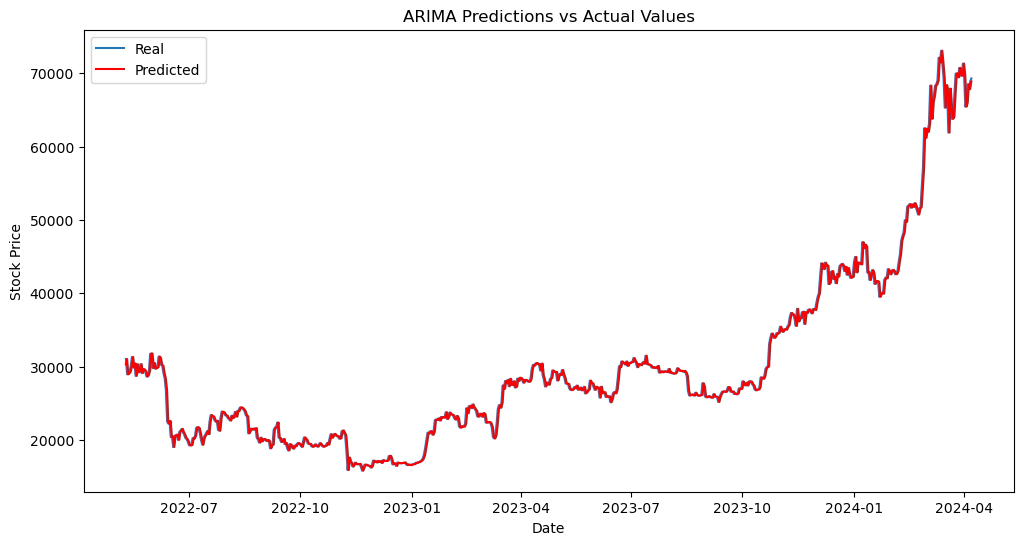

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6), dpi=100)
plt.plot(dataset_ex_df.iloc[size:,:].index, test, label='Real')
plt.plot(dataset_ex_df.iloc[size:,:].index, predictions, color='red', label='Predicted')
plt.title('ARIMA Predictions vs Actual Values')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

C:\Users\jasvi\anaconda3\Lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


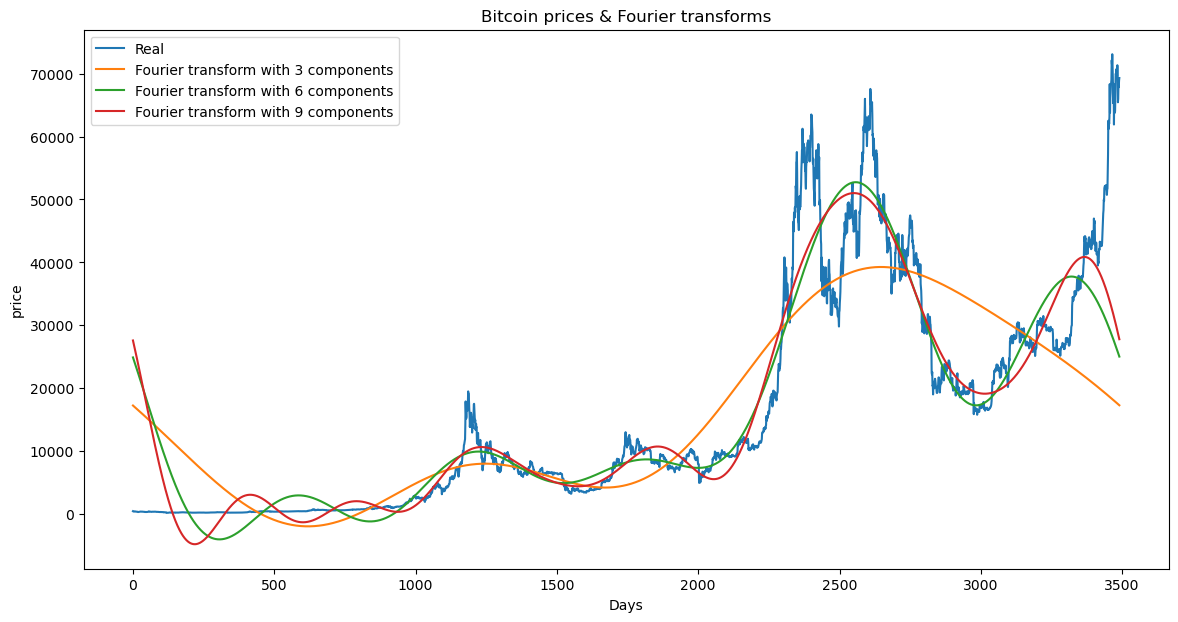

In [215]:
# Calculate the Fourier Transform
data_FT = dataset_ex_df[['Close']]
close_fft = np.fft.fft(np.asarray(data_FT['Close'].tolist()))
fft_df = pd.DataFrame({'fft':close_fft})
fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))

# Plot the Fourier Transforms
plt.figure(figsize=(14, 7), dpi=100)
plt.plot(np.asarray(data_FT['Close'].tolist()),  label='Real')
for num_ in [3, 6, 9]:
    fft_list_m10= np.copy(close_fft); fft_list_m10[num_:-num_]=0
    plt.plot(np.fft.ifft(fft_list_m10), label='Fourier transform with {} components'.format(num_))
plt.xlabel('Days')
plt.ylabel('price')
plt.title('Bitcoin prices & Fourier transforms')
plt.legend()
plt.show()

In [216]:
# Calculate EMA
def ema(close, period=20):
    return close.ewm(span=period, adjust=False).mean()

# Calculate RSI
def rsi(close, period=14):
    delta = close.diff()
    gain, loss = delta.copy(), delta.copy()
    gain[gain < 0] = 0
    loss[loss > 0] = 0
    avg_gain = gain.rolling(period).mean()
    avg_loss = abs(loss.rolling(period).mean())
    rs = avg_gain / avg_loss
    rsi = 100.0 - (100.0 / (1.0 + rs))
    return rsi

# Calculate MACD
def macd(close, fast_period=12, slow_period=26, signal_period=9):
    fast_ema = close.ewm(span=fast_period, adjust=False).mean()
    slow_ema = close.ewm(span=slow_period, adjust=False).mean()
    macd_line = fast_ema - slow_ema
    signal_line = macd_line.ewm(span=signal_period, adjust=False).mean()
    histogram = macd_line - signal_line
    return macd_line

# Calculate OBV
def obv(close, volume):
    obv = np.where(close > close.shift(), volume, np.where(close < close.shift(), -volume, 0)).cumsum()
    return obv

In [217]:
maindf['Close'].ewm(span=20, adjust=False).mean()

0         457.334015
1         454.201252
2         448.543608
3         444.768406
4         440.392464
            ...     
3486    67637.540399
3487    67720.521671
3488    67731.675857
3489    67842.574287
3490    67981.333581
Name: Close, Length: 3491, dtype: float64

In [218]:
dataset_ex_df['ema_20'] = dataset_ex_df['Close'].ewm(span=20, adjust=False).mean()

In [219]:
dataset_ex_df['ema_50'] = dataset_ex_df['Close'].ewm(span=50, adjust=False).mean()
dataset_ex_df['ema_100'] = dataset_ex_df['Close'].ewm(span=100, adjust=False).mean()

In [220]:
dataset_ex_df['rsi'] = rsi(dataset_ex_df["Close"])

In [221]:
dataset_ex_df['macd'] = macd(dataset_ex_df["Close"])

In [222]:
dataset_ex_df['obv'] = obv(dataset_ex_df["Close"], maindf['Volume'])

In [223]:
dataset_ex_df

,Close,ema_20,ema_50,ema_100,rsi,macd,obv
Date,,,,,,,
2014-09-17,457.334015,457.334015,457.334015,457.334015,NaN,0.000000,0
2014-09-18,424.440002,454.201252,456.044054,456.682648,NaN,-2.624024,-34483200
2014-09-19,394.795990,448.543608,453.642169,455.457170,NaN,-7.014744,-72402900
2014-09-20,408.903992,444.768406,451.887731,454.535325,NaN,-9.249402,-35539300
2014-09-21,398.821014,440.392464,449.806683,453.432071,NaN,-11.699137,-62119400
...,...,...,...,...,...,...,...
2024-04-03,65980.812500,67637.540399,62925.509404,56001.498484,45.478606,1268.097018,1702846389365
2024-04-04,68508.843750,67720.521671,63144.463692,56249.168688,57.023754,1202.720402,1737285916807
2024-04-05,67837.640625,67731.675857,63328.509847,56478.643379,59.929290,1084.249922,1703537686751


In [224]:


# Create arima DF using predictions
arima_df = pd.DataFrame(history, index=dataset_ex_df.index, columns=['ARIMA'])

# Set Fourier Transforms DF
fft_df.reset_index(inplace=True)
fft_df['index'] = pd.to_datetime(dataset_ex_df.index)
fft_df.set_index('index', inplace=True)
fft_df_real = pd.DataFrame(np.real(fft_df['fft']), index=fft_df.index, columns=['Fourier_real'])
fft_df_imag = pd.DataFrame(np.imag(fft_df['fft']), index=fft_df.index, columns=['Fourier_imag'])

# Technical Indicators DF
technical_indicators_df = dataset_ex_df[['ema_20', 'ema_50', 'ema_100', 'rsi', 'macd', 'obv', 'Close']]


In [225]:

# Merge DF
merged_df = pd.concat([arima_df, fft_df_real, fft_df_imag, technical_indicators_df], axis=1)
merged_df = merged_df.dropna()
merged_df

,ARIMA,Fourier_real,Fourier_imag,ema_20,ema_50,ema_100,rsi,macd,obv,Close
2014-10-01,383.614990,-1.711783e+06,2.905640e+06,412.179660,432.817230,443.588805,31.461697,-17.993146,-134457600,383.614990
2014-10-02,375.071991,1.409852e+06,-1.026254e+04,408.645597,430.552711,442.232036,35.852649,-18.690770,-156235300,375.071991
2014-10-03,359.511993,1.642978e+06,4.136717e+06,403.966206,427.766800,440.594016,39.000831,-20.265595,-187136500,359.511993
2014-10-04,328.865997,-1.928046e+06,3.217310e+06,396.813805,423.888337,438.381580,27.381697,-23.713179,-234373000,328.865997
2014-10-05,320.510010,2.550773e+05,-7.598605e+05,389.546777,419.834285,436.047489,27.651598,-26.810617,-317681096,320.510010
...,...,...,...,...,...,...,...,...,...,...
2024-04-03,65980.812500,-1.658405e+06,-1.058986e+07,67637.540399,62925.509404,56001.498484,45.478606,1268.097018,1702846389365,65980.812500
2024-04-04,68508.843750,8.846620e+06,-1.007159e+07,67720.521671,63144.463692,56249.168688,57.023754,1202.720402,1737285916807,68508.843750
2024-04-05,67837.640625,1.038364e+07,4.084253e+06,67731.675857,63328.509847,56478.643379,59.929290,1084.249922,1703537686751,67837.640625
2024-04-06,68896.109375,-8.332791e+06,-6.928322e+06,67842.574287,63546.847083,56724.533795,61.393228,1063.511299,1723505472560,68896.109375


In [226]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Shuffling the DataFrame
shuffled_df = merged_df.sample(frac=1, random_state=42)  # Shuffle with random state for reproducibility

# Separate into Train and Test Dfs
train_size = int(len(shuffled_df) * 0.8)
train_df, test_df = shuffled_df.iloc[:train_size], shuffled_df.iloc[train_size:]

# Scale the features
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_df.drop('Close', axis=1))
test_scaled = scaler.transform(test_df.drop('Close', axis=1))

# Convert the scaled data back to a DataFrame
train_scaled_df = pd.DataFrame(train_scaled, columns=train_df.columns[:-1], index=train_df.index)
test_scaled_df = pd.DataFrame(test_scaled, columns=test_df.columns[:-1], index=test_df.index)

# Merge the scaled features with the target variable
train_scaled_df['Close'] = train_df['Close']
test_scaled_df['Close'] = test_df['Close']

# Split the scaled data into Features and Label
X_train = train_scaled_df.iloc[:, :-1].values
y_train = train_scaled_df.iloc[:, -1].values
X_test = test_scaled_df.iloc[:, :-1].values
y_test = test_scaled_df.iloc[:, -1].values


In [227]:
from sklearn.preprocessing import MinMaxScaler

# Scale the features
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_df.drop('Close', axis=1))
test_scaled = scaler.transform(test_df.drop('Close', axis=1))

# Convert the scaled data back to a DataFrame
train_scaled_df = pd.DataFrame(train_scaled, columns=train_df.columns[:-1], index=train_df.index)
test_scaled_df = pd.DataFrame(test_scaled, columns=test_df.columns[:-1], index=test_df.index)

# Merge the scaled features with the target variable
train_scaled_df['Close'] = train_df['Close']
test_scaled_df['Close'] = test_df['Close']

# Split the scaled data into Features and Label
X_train = train_scaled_df.iloc[:, :-1].values
y_train = train_scaled_df.iloc[:, -1].values
X_test = test_scaled_df.iloc[:, :-1].values
y_test = test_scaled_df.iloc[:, -1].values

In [228]:
X_train

array([[4.70811747e-01, 4.37695217e-01, 7.11490519e-01, ...,
        9.62333417e-01, 6.23486595e-01, 4.43375534e-01],
       [9.48925192e-02, 4.43213040e-01, 7.18868118e-01, ...,
        7.12491481e-01, 4.75574750e-01, 7.47230721e-02],
       [1.37814213e-03, 4.43330134e-01, 7.30161126e-01, ...,
        4.94305433e-01, 4.78663522e-01, 1.29579775e-04],
       ...,
       [5.31180274e-01, 4.42349261e-01, 7.15536886e-01, ...,
        4.58581711e-01, 4.41776378e-01, 6.35981577e-01],
       [3.12426294e-01, 4.41583896e-01, 7.11158621e-01, ...,
        4.91669269e-01, 5.79212265e-01, 4.78496840e-01],
       [1.26154880e-01, 4.43912110e-01, 7.19500457e-01, ...,
        3.61064571e-01, 4.72195915e-01, 2.72263483e-01]])

In [229]:
y_train

array([34502.820313,  7096.279785,   278.576996, ..., 38904.011719,
       22955.666016,  9375.474609])

In [230]:
y_test

array([  219.184998,  6635.75    ,  1222.050049,  1182.939941,
         998.325012,  3502.656006, 11440.700195,   416.321991,
       54522.402344, 51762.273438,  6191.192871, 37332.855469,
        9856.611328,  6741.75    ,  1231.920044,   902.200989,
       44162.691406, 48902.402344,  7204.771484, 16908.236328,
       16353.365234, 51662.996094,   658.078003,   267.959991,
         345.488007, 34538.480469,   609.241028,   310.737   ,
       49742.441406, 11474.900391, 23289.314453, 17364.865234,
        8393.041992,  9888.610352,  8094.319824,   236.121002,
         420.735992,  5982.45752 ,   384.263   , 23957.529297,
        9199.584961,  7354.129883,  4257.419922, 63503.457031,
       27583.677734,  9758.852539,  3745.950684, 10106.299805,
       36952.984375,  6580.629883, 13075.248047, 19110.546875,
        5831.16748 , 14973.299805,  3896.543701, 44963.074219,
        1848.569946, 46848.777344,   630.856995, 39105.148438,
         238.871994,   610.892029, 69892.828125, 10233.

In [231]:
# Import keras modules
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

# Define model
model = Sequential()
model.add(Dense(32, activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='linear'))

# Compile the model
model.compile(optimizer='adam', loss='mse')


# Define the early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1, mode='min')

# Train the model with early stopping callback
history = model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1, validation_data=(X_test, y_test), callbacks=[early_stop], shuffle=False)

Epoch 1/100
87/87 [==============================] - 1s 3ms/step - loss: 549018752.0000 - val_loss: 557639168.0000
Epoch 2/100
87/87 [==============================] - 0s 2ms/step - loss: 548153536.0000 - val_loss: 555870976.0000
Epoch 3/100
87/87 [==============================] - 0s 2ms/step - loss: 545086400.0000 - val_loss: 551050496.0000
Epoch 4/100
87/87 [==============================] - 0s 2ms/step - loss: 538236992.0000 - val_loss: 541488192.0000
Epoch 5/100
87/87 [==============================] - 0s 2ms/step - loss: 526091840.0000 - val_loss: 525993568.0000
Epoch 6/100
87/87 [==============================] - 0s 1ms/step - loss: 507811520.0000 - val_loss: 503991232.0000
Epoch 7/100
87/87 [==============================] - 0s 1ms/step - loss: 483090400.0000 - val_loss: 475470496.0000
Epoch 8/100
87/87 [==============================] - 0s 1ms/step - loss: 452233792.0000 - val_loss: 441080064.0000
Epoch 9/100
87/87 [==============================] - 0s 2ms/step - loss: 4162050

In [233]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score

import numpy as np
y_pred = model.predict(X_test)

# Calculate test metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

r2 = r2_score(y_test, y_pred)
evs = explained_variance_score(y_test, y_pred)

mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
mpe = np.mean((y_test - y_pred) / y_test) * 100

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R2 Score: {r2}")
print(f"Explained Variance Score: {evs}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}")
print(f"Mean Percentage Error (MPE): {mpe}")

print("Train data MGD: ", mean_gamma_deviance(y_test, y_pred))
print("Test data MGD: ", mean_gamma_deviance(y_test, y_pred))
print("----------------------------------------------------------------------")
print("Train data MPD: ", mean_poisson_deviance(y_test, y_pred))
print("Test data MPD: ", mean_poisson_deviance(y_test, y_pred))

22/22 [==============================] - 0s 810us/step
Mean Squared Error (MSE): 2719022.459597132
Mean Absolute Error (MAE): 1108.30494165206
R2 Score: 0.9909669934086843
Explained Variance Score: 0.9909779566662223
Mean Absolute Percentage Error (MAPE): 1097.8364647109088
Mean Percentage Error (MPE): -1027.6850031700212
Train data MGD:  0.09668068440295086
Test data MGD:  0.09668068440295086
----------------------------------------------------------------------
Train data MPD:  166.1740224252476
Test data MPD:  166.1740224252476


In [91]:
print("hi")

hi


In [93]:
merged_df

,ARIMA,Fourier_real,Fourier_imag,ema_20,ema_50,ema_100,rsi,macd,obv,Close
2014-10-01,383.614990,-1.711783e+06,2.905640e+06,412.179660,432.817230,443.588805,31.461697,-17.993146,-134457600,383.614990
2014-10-02,375.071991,1.409852e+06,-1.026254e+04,408.645597,430.552711,442.232036,35.852649,-18.690770,-156235300,375.071991
2014-10-03,359.511993,1.642978e+06,4.136717e+06,403.966206,427.766800,440.594016,39.000831,-20.265595,-187136500,359.511993
2014-10-04,328.865997,-1.928046e+06,3.217310e+06,396.813805,423.888337,438.381580,27.381697,-23.713179,-234373000,328.865997
2014-10-05,320.510010,2.550773e+05,-7.598605e+05,389.546777,419.834285,436.047489,27.651598,-26.810617,-317681096,320.510010
...,...,...,...,...,...,...,...,...,...,...
2024-04-03,65980.812500,-1.658405e+06,-1.058986e+07,67637.540399,62925.509404,56001.498484,45.478606,1268.097018,1702846389365,65980.812500
2024-04-04,68508.843750,8.846620e+06,-1.007159e+07,67720.521671,63144.463692,56249.168688,57.023754,1202.720402,1737285916807,68508.843750
2024-04-05,67837.640625,1.038364e+07,4.084253e+06,67731.675857,63328.509847,56478.643379,59.929290,1084.249922,1703537686751,67837.640625
2024-04-06,68896.109375,-8.332791e+06,-6.928322e+06,67842.574287,63546.847083,56724.533795,61.393228,1063.511299,1723505472560,68896.109375


In [94]:
# Separate in Train and Test Dfs
train_size = int(len(merged_df) * 0.8)
train_df, test_df = merged_df.iloc[:train_size], merged_df.iloc[train_size:]

In [95]:
from sklearn.preprocessing import MinMaxScaler

# Scale the features
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_df.drop('Close', axis=1))
test_scaled = scaler.transform(test_df.drop('Close', axis=1))

# Convert the scaled data back to a DataFrame
train_scaled_df = pd.DataFrame(train_scaled, columns=train_df.columns[:-1], index=train_df.index)
test_scaled_df = pd.DataFrame(test_scaled, columns=test_df.columns[:-1], index=test_df.index)

# Merge the scaled features with the target variable
train_scaled_df['Close'] = train_df['Close']
test_scaled_df['Close'] = test_df['Close']

# Split the scaled data into Features and Label
X_train = train_scaled_df.iloc[:, :-1].values
y_train = train_scaled_df.iloc[:, -1].values
X_test = test_scaled_df.iloc[:, :-1].values
y_test = test_scaled_df.iloc[:, -1].values

In [96]:
# Import keras modules
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

# Define model
model = Sequential()
model.add(Dense(32, activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='linear'))

# Compile the model
model.compile(optimizer='adam', loss='mse')


# Define the early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1, mode='min')

# Train the model with early stopping callback
history = model.fit(X_train, y_train, epochs=1000, batch_size=32, verbose=1, validation_data=(X_test, y_test), callbacks=[early_stop], shuffle=False)

Epoch 1/1000
87/87 [==============================] - 1s 3ms/step - loss: 426475104.0000 - val_loss: 1046868480.0000
Epoch 2/1000
87/87 [==============================] - 0s 2ms/step - loss: 426227008.0000 - val_loss: 1046134592.0000
Epoch 3/1000
87/87 [==============================] - 0s 2ms/step - loss: 425781568.0000 - val_loss: 1044839872.0000
Epoch 4/1000
87/87 [==============================] - 0s 2ms/step - loss: 425039808.0000 - val_loss: 1042750080.0000
Epoch 5/1000
87/87 [==============================] - 0s 3ms/step - loss: 423908672.0000 - val_loss: 1039647872.0000
Epoch 6/1000
87/87 [==============================] - 0s 2ms/step - loss: 422280224.0000 - val_loss: 1035230208.0000
Epoch 7/1000
87/87 [==============================] - 0s 2ms/step - loss: 420057376.0000 - val_loss: 1029342976.0000
Epoch 8/1000
87/87 [==============================] - 0s 2ms/step - loss: 417190144.0000 - val_loss: 1021842368.0000
Epoch 9/1000
87/87 [==============================] - 0s 2ms/ste

In [97]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score

import numpy as np
y_pred = model.predict(X_test)

# Calculate test metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

r2 = r2_score(y_test, y_pred)
evs = explained_variance_score(y_test, y_pred)

mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
mpe = np.mean((y_test - y_pred) / y_test) * 100

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R2 Score: {r2}")
print(f"Explained Variance Score: {evs}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}")
print(f"Mean Percentage Error (MPE): {mpe}")

22/22 [==============================] - 0s 1ms/step
Mean Squared Error (MSE): 1050384.8246122787
Mean Absolute Error (MAE): 551.5813465161638
R2 Score: 0.9931865830482752
Explained Variance Score: 0.993524281844181
Mean Absolute Percentage Error (MAPE): 42.7887126092684
Mean Percentage Error (MPE): -14.3256143915542


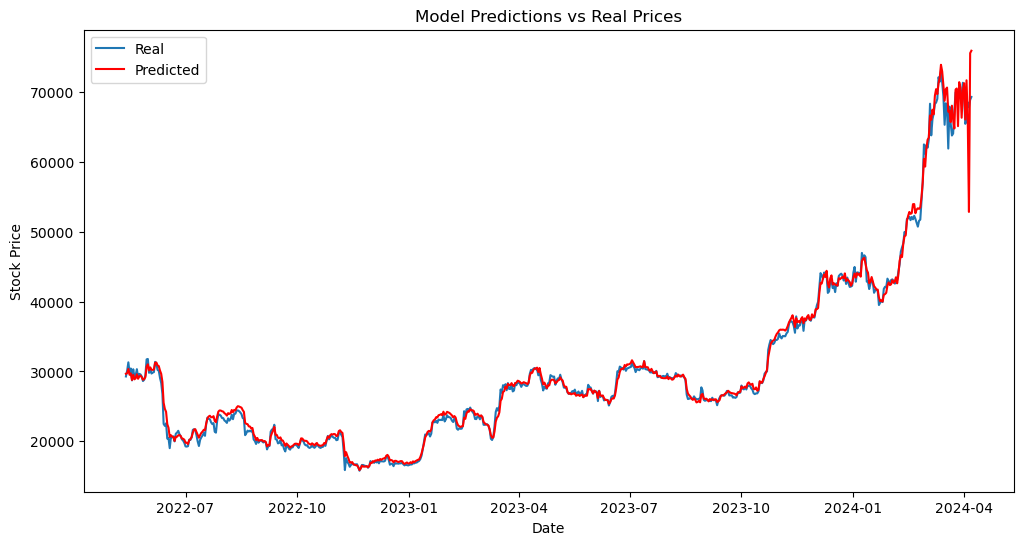

In [99]:
# Plot final Predictions
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(test_scaled_df.index, y_test, label='Real')
plt.plot(test_scaled_df.index, y_pred, color='red', label='Predicted')
plt.title('Model Predictions vs Real Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


In [98]:
dataset_ex_df

,Close,ema_20,ema_50,ema_100,rsi,macd,obv
Date,,,,,,,
2014-09-17,457.334015,457.334015,457.334015,457.334015,NaN,0.000000,0
2014-09-18,424.440002,454.201252,456.044054,456.682648,NaN,-2.624024,-34483200
2014-09-19,394.795990,448.543608,453.642169,455.457170,NaN,-7.014744,-72402900
2014-09-20,408.903992,444.768406,451.887731,454.535325,NaN,-9.249402,-35539300
2014-09-21,398.821014,440.392464,449.806683,453.432071,NaN,-11.699137,-62119400
...,...,...,...,...,...,...,...
2024-04-03,65980.812500,67637.540399,62925.509404,56001.498484,45.478606,1268.097018,1702846389365
2024-04-04,68508.843750,67720.521671,63144.463692,56249.168688,57.023754,1202.720402,1737285916807
2024-04-05,67837.640625,67731.675857,63328.509847,56478.643379,59.929290,1084.249922,1703537686751


In [25]:
dataset_ex_df['ema_20'] 

Date
2014-09-17      457.334015
2014-09-18      454.201252
2014-09-19      448.543608
2014-09-20      444.768406
2014-09-21      440.392464
                  ...     
2024-04-03    67637.540399
2024-04-04    67720.521671
2024-04-05    67731.675857
2024-04-06    67842.574287
2024-04-07    67981.333581
Name: ema_20, Length: 3491, dtype: float64

In [101]:
import torch
import torch.nn as nn


In [102]:
encoder_layer = nn.TransformerEncoderLayer(
    d_model=channels,
    nhead=8,
    dropout=self.dropout,
    dim_feedforward=4 * channels,
)
decoder_layer = nn.TransformerDecoderLayer(
    d_model=channels,
    nhead=8,
    dropout=self.dropout,
    dim_feedforward=4 * channels,
)

self.encoder = torch.nn.TransformerEncoder(encoder_layer, num_layers=8)
self.decoder = torch.nn.TransformerDecoder(decoder_layer, num_layers=8)

NameError: name 'channels' is not defined

In [103]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [119]:
df = pd.read_csv(r"C:\Users\jasvi\Downloads\bitcoin.csv")

In [120]:
df=df[2407:3392]


In [121]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
2407,2021-04-20,55681.792969,57062.148438,53448.046875,56473.031250,56473.031250,67849323955
2408,2021-04-21,56471.128906,56757.972656,53695.468750,53906.089844,53906.089844,54926612466
2409,2021-04-22,53857.105469,55410.230469,50583.812500,51762.273438,51762.273438,74798630778
2410,2021-04-23,51739.808594,52120.792969,47714.664063,51093.652344,51093.652344,86668667320
2411,2021-04-24,51143.226563,51167.562500,48805.285156,50050.867188,50050.867188,49014494781
...,...,...,...,...,...,...,...
3387,2023-12-26,43599.847656,43603.175781,41676.488281,42520.402344,42520.402344,30026850982
3388,2023-12-27,42518.468750,43683.160156,42167.582031,43442.855469,43442.855469,25260941032
3389,2023-12-28,43468.199219,43804.781250,42318.550781,42627.855469,42627.855469,22992093014
3390,2023-12-29,42614.644531,43124.324219,41424.062500,42099.402344,42099.402344,26000021055


In [122]:
df.shape

(985, 7)

In [123]:
df['Date'] = pd.to_datetime(df['Date'])
df['Month']= df['Date'].dt.month
import calendar
df['Month_Name'] = df['Month'].map(lambda x: calendar.month_name[x])

In [124]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 985 entries, 2407 to 3391
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        985 non-null    datetime64[ns]
 1   Open        985 non-null    float64       
 2   High        985 non-null    float64       
 3   Low         985 non-null    float64       
 4   Close       985 non-null    float64       
 5   Adj Close   985 non-null    float64       
 6   Volume      985 non-null    int64         
 7   Month       985 non-null    int64         
 8   Month_Name  985 non-null    object        
dtypes: datetime64[ns](1), float64(5), int64(2), object(1)
memory usage: 69.4+ KB


In [125]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume,Month
count,985.000000,985.000000,985.000000,985.000000,985.000000,9.850000e+02,985.000000
mean,33408.737399,34111.152917,32627.836007,33391.093903,33391.093903,2.791795e+10,6.982741
std,11984.759517,12307.152618,11588.561470,11959.336634,11959.336634,1.437508e+10,3.305992
min,15782.300781,16253.047852,15599.046875,15787.284180,15787.284180,5.331173e+09,1.000000
25%,23469.412109,23919.890625,23077.650391,23471.871094,23471.871094,1.757056e+10,4.000000
50%,30147.070313,30601.740234,29638.095703,30145.888672,30145.888672,2.628817e+10,7.000000
75%,42091.753906,42775.777344,40961.097656,42099.402344,42099.402344,3.456909e+10,10.000000
max,67549.734375,68789.625000,66382.062500,67566.828125,67566.828125,1.263581e+11,12.000000


In [126]:
df.isna().sum()*100/df.shape[0]

Date          0.0
Open          0.0
High          0.0
Low           0.0
Close         0.0
Adj Close     0.0
Volume        0.0
Month         0.0
Month_Name    0.0
dtype: float64

In [127]:
df.dropna(inplace=True)

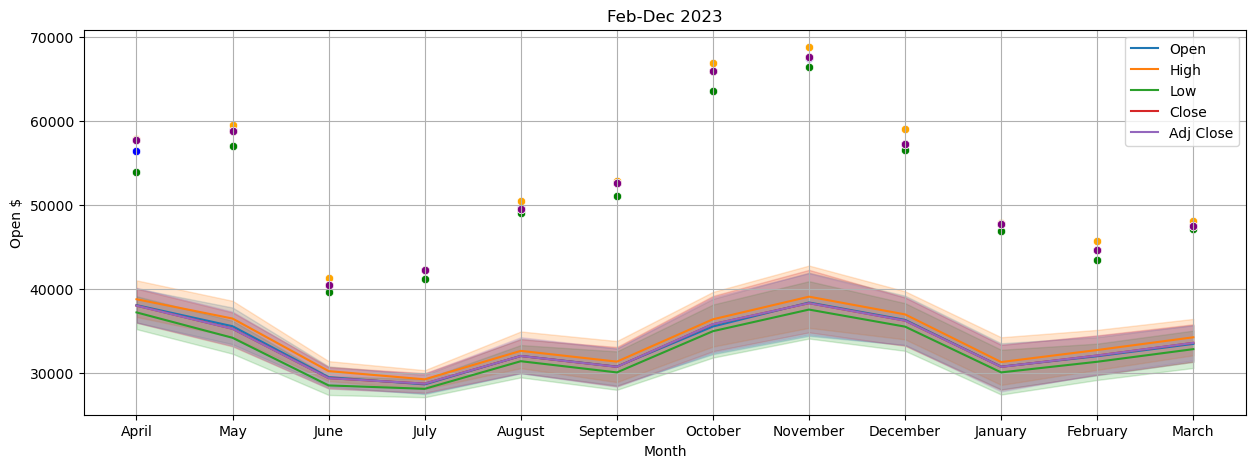

In [128]:
monthly_max_values = df.groupby('Month_Name').agg({'Open': 'max', 'High': 'max', 'Low': 'max', 'Close': 'max', 'Adj Close': 'max'}).reset_index()

plt.figure(figsize=(15,5))
sns.lineplot(data=df,x='Month_Name',y='Open',label='Open')
sns.lineplot(data=df,x='Month_Name',y='High',label='High')
sns.lineplot(data=df,x='Month_Name',y='Low',label='Low')
sns.lineplot(data=df,x='Month_Name',y='Close',label='Close')
sns.lineplot(data=df,x='Month_Name',y='Adj Close',label='Adj Close')
sns.scatterplot(data=monthly_max_values, x='Month_Name', y='Open', marker='o', color='blue')
sns.scatterplot(data=monthly_max_values, x='Month_Name', y='High', marker='o', color='orange')
sns.scatterplot(data=monthly_max_values, x='Month_Name', y='Low', marker='o', color='green')
sns.scatterplot(data=monthly_max_values, x='Month_Name', y='Close', marker='o', color='red')
sns.scatterplot(data=monthly_max_values, x='Month_Name', y='Adj Close', marker='o', color='purple')
plt.grid()
plt.xlabel('Month')
plt.ylabel('Open $')
plt.title('Feb-Dec 2023')
plt.show()

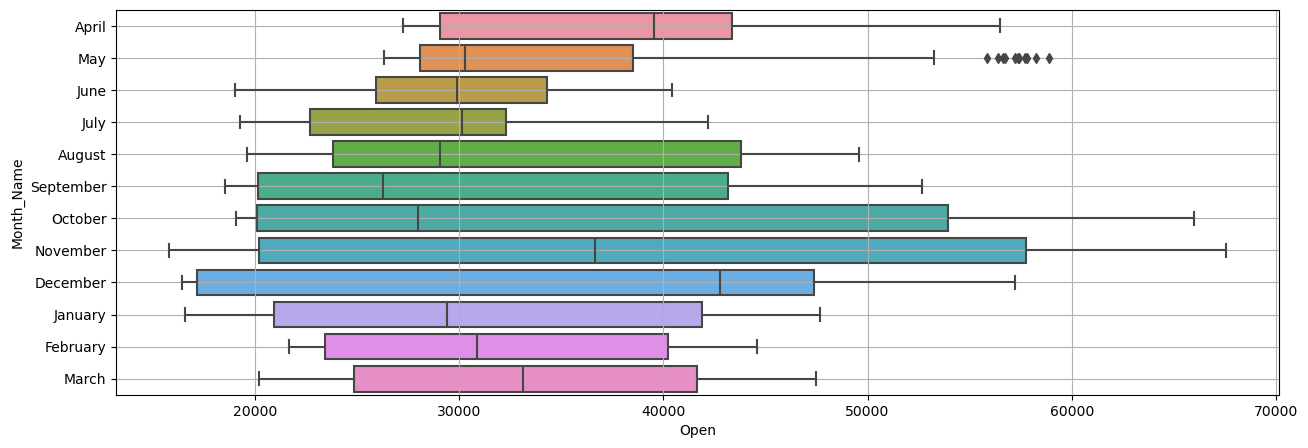

In [129]:
plt.figure(figsize=(15,5))
sns.boxplot(data=df,y='Month_Name',x='Open')
plt.grid()
plt.show()

In [130]:
df = df.drop(columns=['Date','Month_Name'], axis=1)

In [131]:
# Split of Target and Other field
X = df.drop(columns='Low',axis=1)
y = df['Low'] 

In [132]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)

In [133]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train),columns=X_train.columns)
X_test = pd.DataFrame(scaler.fit_transform(X_test),columns=X_test.columns)

In [134]:
from scipy.stats import pearsonr
alpha = 0.05
for i in X_train.columns:
    print('*'*50)
    pstat,pvalue=pearsonr(X_train[i],y_train)
    print('Column Name:',i)
    if pvalue<alpha:
        print('P-value:',pvalue)
        print('Reject Null Hypothesis. Thus we can say that there\nis Linear Correlation between \nIndependent and Dependent field.')
    else:
        print('P-value:',pvalue)
        print('Failed to Reject Null Hypothesis. No correlation.')
    print('.'*50)

**************************************************
Column Name: Open
P-value: 0.0
Reject Null Hypothesis. Thus we can say that there
is Linear Correlation between 
Independent and Dependent field.
..................................................
**************************************************
Column Name: High
P-value: 0.0
Reject Null Hypothesis. Thus we can say that there
is Linear Correlation between 
Independent and Dependent field.
..................................................
**************************************************
Column Name: Close
P-value: 0.0
Reject Null Hypothesis. Thus we can say that there
is Linear Correlation between 
Independent and Dependent field.
..................................................
**************************************************
Column Name: Adj Close
P-value: 0.0
Reject Null Hypothesis. Thus we can say that there
is Linear Correlation between 
Independent and Dependent field.
..................................................
**

In [135]:
import statsmodels.api as sm


from statsmodels.stats.outliers_influence import variance_inflation_factor
def calculate_vif(data_frame):
    vif_data = pd.DataFrame()
    vif_data["feature"] = data_frame.columns
    vif_data["VIF"] = [calculate_individual_vif(data_frame, i) for i in range(data_frame.shape[1])]
    return vif_data
def calculate_individual_vif(data_frame, idx):
    exog = data_frame.drop(data_frame.columns[idx], axis=1)
    model = sm.OLS(data_frame.iloc[:, idx], sm.add_constant(exog))
    results = model.fit()
    
    # Check if R-squared is exactly 1.0
    if np.isclose(results.rsquared, 1.0):
        vif = np.inf
    else:
        vif = 1. / (1. - results.rsquared)
    return vif
def remove_high_vif_features(data_frame, threshold=5):
    while True:
        vif_results = calculate_vif(data_frame)
        max_vif_feature = vif_results.loc[vif_results['VIF'].idxmax()]

        if max_vif_feature['VIF'] > threshold:
            print(f"Removing feature '{max_vif_feature['feature']}' with VIF: {max_vif_feature['VIF']}")
            data_frame = data_frame.drop(max_vif_feature['feature'], axis=1)
        else:
            break

    return data_frame

# Example usage
X_train = remove_high_vif_features(X_train, threshold=5)
#X_test = X_test[X_train.columns]
print('*'*50)
# Display the final DataFrame after removing high VIF features
print("Final DataFrame after removing high VIF features:\n", X_train)

Removing feature 'Close' with VIF: inf
Removing feature 'High' with VIF: 872.8424328966588
Removing feature 'Open' with VIF: 102.83659232134667
**************************************************
Final DataFrame after removing high VIF features:
      Adj Close    Volume     Month
0     0.829435 -0.742670  1.517307
1    -0.571987 -1.194880 -0.621580
2     0.623627 -0.544937 -1.232691
3    -0.624642 -1.271635  0.600641
4    -1.198106 -0.645849  0.906197
..         ...       ...       ...
783   0.499027 -0.169165  0.295086
784   0.783875 -0.670796 -1.843802
785  -0.633869 -1.198746  0.295086
786  -1.132337 -0.299554 -0.316025
787   0.655050 -0.138335 -0.010470

[788 rows x 3 columns]


In [201]:
X_test=X_test[X_train.columns]

In [202]:
from sklearn.linear_model import LinearRegression

model=LinearRegression()
model.fit(X_train,y_train)

LinearRegression()

In [203]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

In [204]:
print('Accuracy Train Dataset:',model.score(X_train,y_train)*100)
print('Accuracy Test Dataset :',model.score(X_test,y_test)*100)

Accuracy Train Dataset: 99.81696524145381
Accuracy Test Dataset : 99.72521415402147


In [207]:
print('Accuracy for Dec 2023 (1 Month):',model.score(test,y)*100,'%')

C:\Users\jasvi\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


ValueError: X has 1 features, but LinearRegression is expecting 6 features as input.

In [205]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

In [206]:

print(classification_report(y_test, y_test_pred))

ValueError: continuous is not supported

In [155]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim,
                        dropout=0, attention_axes=None):
  """
  Creates a single transformer block.
  """
  x = layers.LayerNormalization(epsilon=1e-6)(inputs)
  x = layers.MultiHeadAttention(
      key_dim=head_size, num_heads=num_heads, dropout=dropout,
      attention_axes=attention_axes
      )(x, x)
  x = layers.Dropout(dropout)(x)
  res = x + inputs

    # Feed Forward Part
  x = layers.LayerNormalization(epsilon=1e-6)(res)
  x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
  x = layers.Dropout(dropout)(x)
  x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
  return x + res


In [157]:
import tensorflow as tf
def build_transfromer(head_size, 
                      num_heads,
                      ff_dim,
                      num_trans_blocks,
                      mlp_units, dropout=0, mlp_dropout=0) -> tf.keras.Model:
  """
  Creates final model by building many transformer blocks.
  """
  n_timesteps, n_features, n_outputs = 5, 1, 5 
  inputs = tf.keras.Input(shape=(n_timesteps, n_features))
  x = inputs 
  for _ in range(num_trans_blocks):
    x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)
  
  x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
  for dim in mlp_units:
    x = layers.Dense(dim, activation="relu")(x)
    x = layers.Dropout(mlp_dropout)(x)

  outputs = layers.Dense(n_outputs, activation='relu')(x)
  return tf.keras.Model(inputs, outputs)

transformer = build_transfromer(head_size=128, num_heads=4, ff_dim=2, 
                                num_trans_blocks=4, mlp_units=[256], 
                                mlp_dropout=0.10, dropout=0.10, 
                                attention_axes=1)

TypeError: build_transfromer() got an unexpected keyword argument 'attention_axes'

In [234]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import copy
import math
import time
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from torch.nn import TransformerEncoder, TransformerEncoderLayer

In [235]:
USE_CUDA = torch.cuda.is_available()
device = torch.device('cuda:0' if USE_CUDA else 'cpu')
input_window = 7 # number of input time steps
output_window = 1 # number of prediction steps (equals to one)
batch_size = 100

In [236]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout_p=0.1, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(dropout_p)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return self.dropout(x + self.pe[:x.size(0), :])

In [237]:
class Transformer(nn.Module):
    def __init__(self, feature_size=200, num_layers=2, dropout=0.1):
        # feautre_size equals to embedding dimension (d_model)
        super().__init__()
        self.model_type = 'Transformer'

        self.src_mask = None
        self.pos_encoder = PositionalEncoding(feature_size)
        
        # Apply nhead multi-head attention
        # d_key, d_query, d_value = d_model // n_head
        self.encoder_layer = TransformerEncoderLayer(d_model=feature_size, nhead=10, dropout=dropout)
        
        # Use num_layers encoders
        self.transformer_encoder = TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        
        # For simple time-series prediction, decoder just uses FC layer
        self.decoder = nn.Linear(feature_size, 1)
        self._init_weights()
    
    def _init_weights(self):
        init_range = 0.1
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-init_range, init_range)

    def forward(self, src):
        if self.src_mask is None or self.src_mask.size(0) != len(src):
            device = src.device
            mask = self._generate_square_subsequent_mask(len(src)).to(device)
            self.src_mask = mask

        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, self.src_mask)
        output = self.decoder(output)
        return output

    def _generate_square_subsequent_mask(self, size):
        mask = torch.tril(torch.ones(size, size) == 1) # Lower Triangular matrix
        mask = mask.float()
        mask = mask.masked_fill(mask == 0, float('-inf')) # Convert zeros to -inf
        mask = mask.masked_fill(mask == 1, float(0.0)) # Convert ones to 0
        return mask
        

In [238]:
def create_inout_sequences(input_data, input_window):
    inout_seq = []
    L = len(input_data)
    for i in range(L - input_window):
        train_seq = input_data[i:i + input_window]
        train_label = input_data[i + output_window: i + input_window + output_window]
        inout_seq.append((train_seq, train_label))
    return torch.FloatTensor(inout_seq)

In [239]:
def get_data(data_raw, split):
    split = round(split * len(data_raw))
    train_data = data_raw[:split]
    test_data = data_raw[split:]

    train_data = train_data.cumsum()
    train_data = 2 * train_data  # Training data scaling

    test_data = test_data.cumsum()

    train_sequence = create_inout_sequences(train_data, input_window)
    train_sequence = train_sequence[:-output_window]

    test_sequence = create_inout_sequences(test_data, input_window)
    test_sequence = test_sequence[:-output_window]

    return train_sequence.to(device), test_sequence.to(device)

In [240]:
close_appl =maindf.Close

In [241]:
log_prices = np.diff(np.log(close_appl))

In [242]:
log_prices_csum = log_prices.cumsum() 

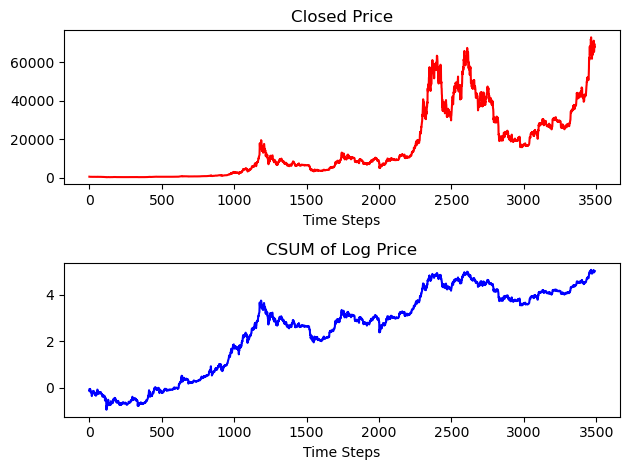

In [243]:
fig1, ax1 = plt.subplots(2, 1)
ax1[0].plot(close_appl, color='red')
ax1[0].set_title('Closed Price')
ax1[0].set_xlabel('Time Steps')

ax1[1].plot(log_prices_csum, color='blue')
ax1[1].set_title('CSUM of Log Price')
ax1[1].set_xlabel('Time Steps')

fig1.tight_layout()

In [244]:
train_data, test_data = get_data(log_prices, 0.7) 

In [245]:
def get_batch(source, i, batch_size):
    seq_len = min(batch_size, len(source) - 1 - i)
    data = source[i:i+seq_len]
    data_in = torch.stack(torch.stack([item[0] for item in data]).chunk(input_window, 1))
    target = torch.stack(torch.stack([item[1] for item in data]).chunk(input_window, 1))
    return data_in, target

In [246]:
def train(train_data):
    model.train() # Turn on the evaluation mode
    total_loss = 0.
    start_time = time.time()

    for batch, i in enumerate(range(0, len(train_data) - 1, batch_size)):
        data, targets = get_batch(train_data, i, batch_size)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, targets)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 0.7)
        optimizer.step()

        total_loss = total_loss + loss.item()
        log_interval = int(len(train_data) / batch_size / 5)
        if batch % log_interval == 0 and batch > 0:
            cur_loss = total_loss / log_interval
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | '
                  'lr {:02.10f} | {:5.2f} ms | '
                  'loss {:5.7f}'.format(
                    epoch, batch, len(train_data) // batch_size, scheduler.get_lr()[0],
                    elapsed * 1000 / log_interval,
                    cur_loss))
            total_loss = 0
            start_time = time.time()

In [247]:
def evaluate(model, data_source):
    model.eval() # Turn on the evaluation mode
    total_loss = 0.
    eval_batch_size = 1000
    with torch.no_grad():
        for i in range(0, len(data_source) - 1, eval_batch_size):
            data, targets = get_batch(data_source, i, eval_batch_size)
            output = model(data)
            total_loss = total_loss + len(data[0]) * criterion(output, targets).cpu().item()
    return total_loss / len(data_source)

In [248]:
def predict(model, sequences):
    start_timer = time.time()
    model.eval()
    predicted_seq = torch.Tensor(0)
    real_seq = torch.Tensor(0)
    with torch.no_grad():
        for i in range(0, len(sequences) - 1):
            data, target = get_batch(sequences, i, 1)
            output = model(data)
            predicted_seq = torch.cat((predicted_seq, output[-1].view(-1).cpu()), 0)
            real_seq = torch.cat((real_seq, target[-1].view(-1).cpu()), 0)
    timed = time.time() - start_timer
    print(f"{timed} sec")

    return predicted_seq, real_seq

In [249]:
model = Transformer().to(device)

criterion = nn.MSELoss() 
lr = 0.00005

optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

N_EPOCHS = 150

C:\Users\jasvi\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [250]:
for epoch in range(1, N_EPOCHS + 1):
    epoch_start_time = time.time()
    train(train_data)

    if (epoch % N_EPOCHS == 0):  # Valid model after last training epoch
        val_loss = evaluate(model, test_data)
        print('-' * 80)
        print('| end of epoch {:3d} | time: {:5.2f}s | valid loss: {:5.7f}'.format(epoch,
                                                                                   (time.time() - epoch_start_time),
                                                                                   val_loss))
        print('-' * 80)

    else:
        print('-' * 80)
        print('| end of epoch {:3d} | time: {:5.2f}s'.format(epoch, (time.time() - epoch_start_time)))
        print('-' * 80)

    scheduler.step()

C:\Users\jasvi\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:384: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch   1 |     4/   24 batches | lr 0.0000500000 | 94.57 ms | loss 0.7671780
| epoch   1 |     8/   24 batches | lr 0.0000500000 | 70.64 ms | loss 0.4139355
| epoch   1 |    12/   24 batches | lr 0.0000500000 | 66.03 ms | loss 10.6136166
| epoch   1 |    16/   24 batches | lr 0.0000500000 | 70.17 ms | loss 4.2269294
| epoch   1 |    20/   24 batches | lr 0.0000500000 | 69.14 ms | loss 1.1253818
| epoch   1 |    24/   24 batches | lr 0.0000500000 | 59.33 ms | loss 3.2291178
--------------------------------------------------------------------------------
| end of epoch   1 | time:  1.72s
--------------------------------------------------------------------------------
| epoch   2 |     4/   24 batches | lr 0.0000451250 | 87.74 ms | loss 3.1630475
| epoch   2 |     8/   24 batches | lr 0.0000451250 | 71.34 ms | loss 28.1843617
| epoch   2 |    12/   24 batches | lr 0.0000451250 | 70.02 ms | loss 13.1510471
| epoch   2 |    16/   24 batches | lr 0.0000451250 | 72.92 ms | loss 5.0691282
|

In [251]:
predicted_seq, real_seq = predict(model, test_data)

1.152099370956421 sec


In [252]:
from sklearn.metrics import mean_absolute_error

# Assuming predicted_seq and real_seq are numpy arrays or PyTorch tensors
mae = mean_absolute_error(real_seq, predicted_seq)

print("Mean Absolute Error (MAE):", mae)


Mean Absolute Error (MAE): 0.047773004


In [253]:
mse = mean_squared_error(real_seq, predicted_seq)
print("MSE:", mse)

MSE: 0.0040316316


In [254]:
r2 = r2_score(real_seq, predicted_seq)
print("r2:",r2)

r2: 0.9713393932178699


In [255]:
evs = explained_variance_score(real_seq, predicted_seq)
print("evs:",evs)

evs: 0.9722655415534973


In [256]:
mape = mean_absolute_percentage_error(real_seq, predicted_seq)
print("mape:",mape)

mape: 0.5483907


In [257]:
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score, mean_absolute_percentage_error

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(real_seq, predicted_seq)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(real_seq, predicted_seq)

# Calculate R2 Score
r2 = r2_score(real_seq, predicted_seq)

# Calculate Explained Variance Score
evs = explained_variance_score(real_seq, predicted_seq)

# Calculate Mean Absolute Percentage Error (MAPE)
mape = mean_absolute_percentage_error(real_seq, predicted_seq)

# Calculate Mean Percentage Error (MPE)
mpe = np.mean((real_seq - predicted_seq) / real_seq) * 100

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R2 Score: {r2}")
print(f"Explained Variance Score: {evs}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}")
print(f"Mean Percentage Error (MPE): {mpe}")


TypeError: mean() received an invalid combination of arguments - got (axis=NoneType, dtype=NoneType, out=NoneType, ), but expected one of:
 * (*, torch.dtype dtype)
 * (tuple of ints dim, bool keepdim, *, torch.dtype dtype)
 * (tuple of names dim, bool keepdim, *, torch.dtype dtype)


In [258]:
predicted_seq

tensor([-0.0508, -0.0550, -0.0511,  ...,  0.5043,  0.5012,  0.4967])

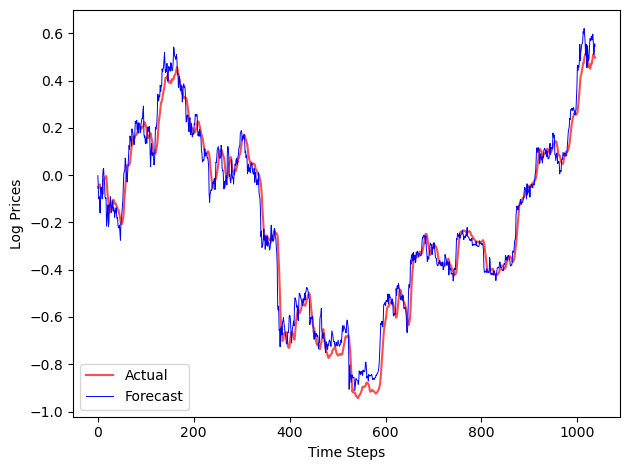

In [259]:
fig2, ax2 = plt.subplots(1, 1)

ax2.plot(predicted_seq, color='red', alpha=0.7)
ax2.plot(real_seq, color='blue', linewidth=0.7)
ax2.legend(['Actual', 'Forecast'])
ax2.set_xlabel('Time Steps')
ax2.set_ylabel('Log Prices')

fig2.tight_layout()

In [260]:
close_msft = maindf.Close
log_prices2 = np.diff(np.log(close_msft))

In [261]:
train_data2, test_data2 = get_data(log_prices2, 0.7)

In [262]:
predicted_seq2, real_seq2 = predict(model, test_data2)

1.1031441688537598 sec


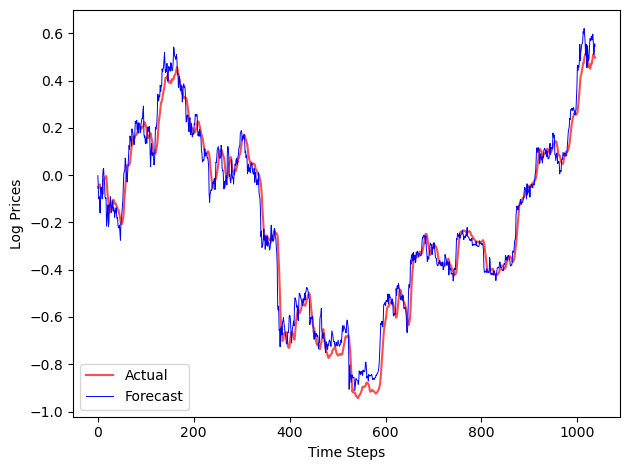

In [263]:
fig3, ax3 = plt.subplots(1, 1)

ax3.plot(predicted_seq2, color='red', alpha=0.7)
ax3.plot(real_seq2, color='blue', linewidth=0.7)
ax3.legend(['Actual', 'Forecast'])
ax3.set_xlabel('Time Steps')
ax3.set_ylabel('Log Prices')

fig3.tight_layout()

In [264]:
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score, mean_absolute_percentage_error

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(real_seq, predicted_seq)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(real_seq, predicted_seq)

# Calculate R2 Score
r2 = r2_score(real_seq, predicted_seq)

# Calculate Explained Variance Score
evs = explained_variance_score(real_seq, predicted_seq)

# Calculate Mean Absolute Percentage Error (MAPE)
mape = mean_absolute_percentage_error(real_seq, predicted_seq)

# Calculate Mean Percentage Error (MPE)
mpe = np.mean((real_seq - predicted_seq) / real_seq) * 100

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R2 Score: {r2}")
print(f"Explained Variance Score: {evs}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}")
print(f"Mean Percentage Error (MPE): {mpe}")


TypeError: mean() received an invalid combination of arguments - got (axis=NoneType, dtype=NoneType, out=NoneType, ), but expected one of:
 * (*, torch.dtype dtype)
 * (tuple of ints dim, bool keepdim, *, torch.dtype dtype)
 * (tuple of names dim, bool keepdim, *, torch.dtype dtype)


In [265]:
real_seq =real_seq.tolist()
predicted_seq=predicted_seq.tolist()

In [266]:
# Convert lists to numpy arrays
real_seq_np = np.array(real_seq)
predicted_seq_np = np.array(predicted_seq)

# Calculate Mean Percentage Error (MPE)
mpe = np.mean(np.abs((real_seq_np - predicted_seq_np) / real_seq_np)) * 100


In [267]:
mpe

54.839068250536315

In [268]:
print("Train data RMSE: ", math.sqrt(mean_squared_error(real_seq, predicted_seq)))
print("Train data MSE: ", mean_squared_error(real_seq, predicted_seq))
print("Train data MAE: ", mean_absolute_error(real_seq, predicted_seq))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(real_seq, predicted_seq)))
print("Test data MSE: ", mean_squared_error(real_seq, predicted_seq))
print("Test data MAE: ", mean_absolute_error(real_seq, predicted_seq))

Train data RMSE:  0.06349513215047284
Train data MSE:  0.00403163180680601
Train data MAE:  0.047773006900621
-------------------------------------------------------------------------------------
Test data RMSE:  0.06349513215047284
Test data MSE:  0.00403163180680601
Test data MAE:  0.047773006900621


In [269]:
print("Train data MGD: ", mean_gamma_deviance(real_seq, predicted_seq))
print("Test data MGD: ", mean_gamma_deviance(real_seq, predicted_seq))
print("----------------------------------------------------------------------")
print("Train data MPD: ", mean_poisson_deviance(real_seq, predicted_seq))
print("Test data MPD: ", mean_poisson_deviance(real_seq, predicted_seq))

ValueError: Mean Tweedie deviance error with power=2 can only be used on strictly positive y and y_pred.